# Dualpol indices on GA's Sentinel-1 data

e.g. The Radar Vegetation Index

## Set-up

### Prepare the environment

You will need to install the required python packages, as described in the [README](README.md) file.

Once you have a python environment with the required libraries, connect the notebook to that environment.

### Import required libraries

In [1]:
import pathlib
import numpy as np
import xarray as xr
from pystac_client import Client
import matplotlib.pyplot as plt
from odc.geo import BoundingBox
from odc.geo.xr import write_cog
from odc.stac import load, configure_s3_access


## Analysis Parameters

In [2]:
# Set the central latitude and longitude
# central_lat = -12.703
# central_lon = 130.647

central_lat, central_lon = -35.9637, 146.4926

# Set the buffer to load around the central coordinates. 
buffer = 0.05

#output crs
crs='EPSG:3577'

# date range to load
start_date = "2024-04-01"
end_date = "2024-12-30"

# Compute the bounding box for the study area
bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs="EPSG:4326"
)

## Load S1 with STAC

In [3]:
catalog = "https://explorer.dev.dea.ga.gov.au/stac"
stac_client = Client.open(catalog)
configure_s3_access(
    cloud_defaults=True, 
    aws_unsigned=True,
)

collections_query = ["ga_s1_iw_vv_vh_c0"]
date_query = f"{start_date}/{end_date}"
bbox_query = bbox.bbox

items = stac_client.search(
    collections=collections_query,
    datetime=date_query,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items")

Found 204 items


In [4]:
# Lazy load our data
ds = load(
    items,
    crs=crs,
    resolution=20,
    bbox=bbox,
    bands=["VV", "VH", "mask"],
    groupby="solar_day",
    chunks={},
)

ds

<xarray.Dataset> Size: 167MB
Dimensions:      (y: 603, x: 512, time: 45)
Coordinates:
  * y            (y) float64 5kB -3.997e+06 -3.997e+06 ... -4.009e+06 -4.009e+06
  * x            (x) float64 4kB 1.299e+06 1.299e+06 ... 1.309e+06 1.309e+06
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 360B 2024-04-06T19:25:05.054253 ... 20...
Data variables:
    VV           (time, y, x) float32 56MB dask.array<chunksize=(1, 603, 512), meta=np.ndarray>
    VH           (time, y, x) float32 56MB dask.array<chunksize=(1, 603, 512), meta=np.ndarray>
    mask         (time, y, x) float32 56MB dask.array<chunksize=(1, 603, 512), meta=np.ndarray>

## Mask for valid data

In [5]:
valid_mask = xr.where(ds.mask>0, False, True)
ds = ds.where(valid_mask).drop_vars('mask')

## Speckle filter

In [6]:
import sys
sys.path.insert(1, '../src/')
from speckle_filters import apply_lee_filter

In [7]:
ds["VV"] = apply_lee_filter(ds.VV, size=5)
ds["VH"] = apply_lee_filter(ds.VH, size=5)

## Calculate dualpol indices

A function has been created for this in the `src/` folder

Available indexes:
* ``'RVI'`` (Radar Vegetation Index for dual-pol, Trudel et al. 2012; Nasirzadehdizaji et al., 2019; Gururaj et al., 2019)
* ``'VDDPI'`` (Vertical dual depolarization index, Periasamy 2018)
* ``'theta'`` (pseudo scattering-type, Bhogapurapu et al. 2021)
* ``'entropy'`` (pseudo scattering entropy, Bhogapurapu et al. 2021)
* ``'purity'`` (co-pol purity, Bhogapurapu et al. 2021)
* ``'ratio'`` (cross-pol/co-pol ratio)

In [8]:
import sys
sys.path.insert(1, '../src/')
from dualpol_indices import dualpol_indices

In [9]:
# Calculate the index(es) and add it to the loaded data set.
# By setting drop=True the VV and VH bands will be removed
ds = dualpol_indices(ds, index=["RVI"], drop=True)

Dropping bands ['VV', 'VH']


### Loading data in memory


In [10]:
ds.load()
ds

/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<xarray.Dataset> Size: 56MB
Dimensions:      (y: 603, x: 512, time: 45)
Coordinates:
  * y            (y) float64 5kB -3.997e+06 -3.997e+06 ... -4.009e+06 -4.009e+06
  * x            (x) float64 4kB 1.299e+06 1.299e+06 ... 1.309e+06 1.309e+06
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 360B 2024-04-06T19:25:05.054253 ... 20...
Data variables:
    RVI          (time, y, x) float32 56MB 0.5493 0.5813 ... 0.4478 0.4509

## Plotting

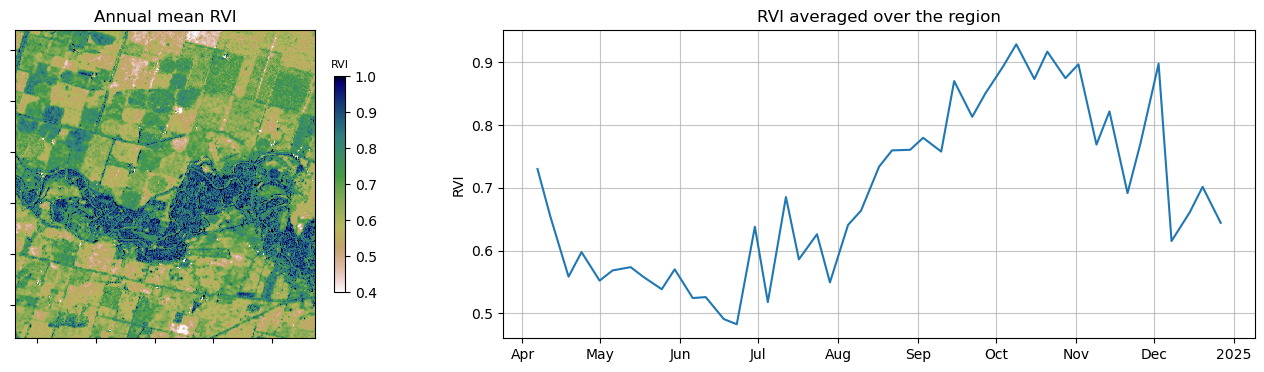

In [11]:
fig, (ax_map, ax_ts) = plt.subplots(
    1,
    2,  # 1 row, 2 columns
    figsize=(16, 4),
    gridspec_kw={"width_ratios": [1, 2]},  # Adjust panel width ratio
)

# add the map to the left side of the figure.
im = ds.RVI.mean("time").plot(
    ax=ax_map,
    cmap="gist_earth_r",
    add_labels=False,
    vmin=0.4,
    vmax=1.0,
    add_colorbar=False,
)

# Manually add a colorbar, this allows us to control the size
cbar = plt.colorbar(im, ax=ax_map, shrink=0.7)
cbar.ax.set_title("RVI", fontsize=8)

# add a title
ax_map.set_title("Annual mean RVI")

# remove the lat/lon tick labels for tidiness
ax_map.set_yticklabels([])
ax_map.set_xticklabels([])

# Now add the NDVI timeseries to the plot, average out the spatial dims so we get a 1D timeseries
ds.RVI.mean(["x", "y"]).plot(ax=ax_ts)
ax_ts.grid(alpha=0.75)
ax_ts.set_title("RVI averaged over the region")
ax_ts.set_xlabel(None);